# Интеллектуальный анализ данных – весна 2024

# Домашнее задание 7: Деревья. Случайный лес

Правила:

- Домашнее задание оценивается в 10 баллов (+1 бонусный балл).


- Можно использовать без доказательства любые результаты, встречавшиеся на лекциях или семинарах по курсу, если получение этих результатов не является вопросом задания.


- Можно использовать любые свободные источники с обязательным указанием ссылки на них.


- Плагиат не допускается. При обнаружении случаев списывания, 0 за работу выставляется всем участникам нарушения, даже если можно установить, кто у кого списал.

<!-- ![](meme.jpg) -->
<img src="meme.jpg" alt="Drawing" style="width: 700px;"/>

## Часть 1: Основы построения решающие дерева (1.5 балла)

В этой части все расчёты необходимо реализовывать в виде запрограммированных формул, например, на `numpy`. **Нельзя использовать готовые реализации**. Например, если в задании требуется рассчитать энтропию, то требуется в каком-то виде релизовать расчёт по формуле, но нельзя использовать готовую реализацию `some_module.entropy()`.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

**Задание 1.1 (0.5 балла)** Пусть известно, что в вершину решающего дерева попали 10 объектов, 8 из которых имеют метку класса $k_1$, а 2 имеют метку класса $k_2$. Рассчитайте энтропию такого распределения классов (с натуральным логарифмом). Ответ округлите до двух знаков после запятой.

In [2]:
entropy=round(-(8/10 * np.log(8/10) + 2/10 * np.log(2/10)),2)

In [3]:
entropy

0.5

**Задание 1.2 (0.5 балла)** Пусть дополнительно известно, что вершина из предыдущего задания не является листовой и возможно такое разбиение, что в левое поддерево попадут все объекты класса $k_1$, а в правое - класса $k_2$. Посчитайте критерий информативности:

$$
Q(R_m, j, t) = H(R_m) - \frac{|R_\ell|}{|R_m|}H(R_\ell) - \frac{|R_r|}{|R_m|}H(R_r),
$$

где $R_m$ - множество объектов в разбиваемой вершине, $j$ - номер признака, по которому происходит разбиение, $t$ - порог разбиения, $R_\ell$ - множество объектов в левом поддереве, $R_r$ - множество объектов в правом поддереве.

Теперь в качестве $H(R)$ будем использовать индекс Джини:

$$
H(R) = \sum_{k=1}^J p_k(1-p_k),
$$
где $J$ – общее количество классов (в нашем случае, $J = 2$).

Ответ округлите до двух знаков после запятой.

In [4]:
entropy_parent= 8/10*(1-8/10)+2/10*(1-2/10)
left_child= 8/10*(1*(1-1)+0*(1-0))
right_child= 2/10*(1*(1-1)+0*(1-0))
Q=entropy_parent-left_child-right_child
Q

0.32

**Задание 1.3 (0.5 балла)** Пусть при построении дерева образовалась листовая вершина с 10 объектами, значения целевой переменной для которых следующие: [1, 10, 5, 18, 100, 30, 50, 61, 84, 47] (решается задача регрессии). Чему будут равны предсказания модели для этих объектов?

In [5]:
predicted=np.mean([1, 10, 5, 18, 100, 30, 50, 61, 84, 47])
predicted

40.6

## Часть 2: Решающие деревья (4.5 балла)

В этой части мы напишем и протестируем собственную реализацию решающего дерева.

In [6]:
from collections import Counter
from typing import Dict, List, Tuple, Union

**Задание 2.1 (1.5 балла)** Реализуйте функцию `find_best_split()`, которая должна находить оптимальное разбиение подмножества обучающей выборки в соответствии с информационным критерием из **Задания 1.2**. В качестве меры хаотичности $H(R)$ для задачи регрессии испольуйте дисперсию подвыборки, а для задачи классификации – критерий Джини (определён в том же задании).

Для категориальных признаков применяется наивный алгоритм разбиения: мы пытаемся найти одно значение, разбиение по которому сильнее всего увеличит критерий информативности. Иными словами, объекты с конкретным значением признака отправляем в левое поддерево, остальные - в правое. Обратите внимание, что это далеко не оптимальные способ учёта категориальных признаков. Например, можно было бы на каждое значение категориального признака создавать отдельное поддерево или использовать более сложные подходы. Подробнее об этом можно прочитать в конспектах [лекций](https://github.com/esokolov/ml-course-hse/blob/master/2019-fall/lecture-notes/lecture07-trees.pdf) по машинному обучению на ПМИ (раздел «Учёт категориальных признаков»).

В качестве подсказок реализации можете пользоваться кодом из бонусной части семинара по решающим деревьям.

**Бонус:** Разрешается делать цикл для перебора порогов, но возможна имплементация без него. За имплементацию без цикла – **бонус 1 балл**.

In [7]:
def find_best_split(
    feature_vector: Union[np.ndarray, pd.DataFrame],
    target_vector: Union[np.ndarray, pd.Series],
    task: str = "classification",
    feature_type: str = "real"
    )     -> Tuple[np.ndarray, np.ndarray, float, float]:

    sorted_feature_vector = np.sort(feature_vector)
    unique_values = np.unique(sorted_feature_vector)
    array = np.column_stack((feature_vector, target_vector))
    sorted_array = array[array[:, 0].argsort()]
    mid=sorted_array
    gini_best = float('-inf')
    threshold_best = 0
    ginis = []

    if feature_type == "real":
        thresholds_real = (unique_values[:-1] + unique_values[1:]) / 2
        thresholds=thresholds_real
        for i in thresholds_real:
            left = sorted_array[sorted_array[:, 0] <= i]
            right = sorted_array[sorted_array[:, 0] > i]
            if len(left) == 0 or len(right) == 0:
                continue

            n_left_total = left.shape[0]
            n_right_total = right.shape[0]
            total = n_left_total + n_right_total

            if task == 'classification':
                class_counts_left = np.unique(left[:, 1], return_counts=True)[1]
                class_counts_right = np.unique(right[:, 1], return_counts=True)[1]
                class_counts_mid = np.unique(sorted_array[:, 1], return_counts=True)[1]


                class_entropies_left = np.sum((n_left_total / total) * (class_counts_left / n_left_total) * (
                            1 - (class_counts_left / n_left_total)))
                class_entropies_right = np.sum((n_right_total / total) * (class_counts_right / n_right_total) * (
                            1 - (class_counts_right / n_right_total)))
                class_entropies_mid = np.sum((class_counts_mid / total) * (
                            1 - (class_counts_mid / total)))


                ginis.append(class_entropies_mid-class_entropies_right-class_entropies_left)

                if class_entropies_mid -class_entropies_left-class_entropies_right > gini_best:
                    gini_best = class_entropies_mid -class_entropies_left-class_entropies_right
                    threshold_best = i

            elif task == 'regression':
                left_answers_column = left[:, 1]
                right_answers_column = right[:, 1]
                mid_answers_column = sorted_array[:, 1]

                left_deviations = (n_left_total) / (total) * (
                            np.sum((left_answers_column - np.mean(left_answers_column)) ** 2) / (n_left_total))
                right_deviations = (n_right_total) / (total) * (
                            np.sum((right_answers_column - np.mean(right_answers_column)) ** 2) / (n_right_total))
                mid_deviations = np.sum((mid_answers_column - np.mean(mid_answers_column)) ** 2) / (total)

                total_deviation = mid_deviations-right_deviations-left_deviations

                ginis.append(total_deviation)
                if total_deviation > gini_best:
                    gini_best = total_deviation
                    threshold_best = i

    elif feature_type == 'categorical':
        thresholds_categorical = np.unique(sorted_feature_vector)
        thresholds = thresholds_categorical
        for i in thresholds_categorical:
            left = sorted_array[sorted_array[:, 0] <= i]
            right = sorted_array[sorted_array[:, 0] > i]

            if len(left) == 0 or len(right) == 0:
                continue

            n_left_total = left.shape[0]
            n_right_total = right.shape[0]
            total = n_left_total + n_right_total

            if task == 'classification':
                class_counts_left = np.unique(left[:, 1], return_counts=True)[1]
                class_counts_right = np.unique(right[:, 1], return_counts=True)[1]
                class_counts_mid = np.unique(sorted_array[:, 1], return_counts=True)[1]

                class_entropies_left = np.sum((n_left_total / total) * (class_counts_left / n_left_total) * (
                            1 - (class_counts_left / n_left_total)))
                class_entropies_right = np.sum((n_right_total / total) * (class_counts_right / n_right_total) * (
                            1 - (class_counts_right / n_right_total)))
                class_entropies_mid = np.sum((class_counts_mid / total) * (
                            1 - (class_counts_mid / total)))


                ginis.append(class_entropies_mid-class_entropies_right-class_entropies_left)

                if class_entropies_mid -class_entropies_left-class_entropies_right > gini_best:
                    gini_best = class_entropies_mid -class_entropies_left-class_entropies_right
                    threshold_best = i

            elif task == 'regression':

              left_answers_column = left[:, 1]
              right_answers_column = right[:, 1]
              mid_answers_column = sorted_array[:, 1]

              left_deviations = (n_left_total) / (total) * (
                            np.sum((left_answers_column - np.mean(left_answers_column)) ** 2) / (n_left_total))
              right_deviations = (n_right_total) / (total) * (
                            np.sum((right_answers_column - np.mean(right_answers_column)) ** 2) / (n_right_total))
              mid_deviations = np.sum((mid_answers_column - np.mean(mid_answers_column)) ** 2) / (total)

              total_deviation = mid_deviations-right_deviations-left_deviations

              ginis.append(total_deviation)
              if total_deviation > gini_best:
                  gini_best = total_deviation
                  threshold_best = i

    return (thresholds, ginis, threshold_best, gini_best)
















    """
    Указания:
    * Пороги, приводящие к попаданию в одно из поддеревьев пустого множества объектов, не рассматриваются.
    * В качестве порогов, нужно брать среднее двух сосдених (при сортировке) значений признака
    * Поведение функции в случае константного признака может быть любым.
    * При одинаковых приростах Джини или дисперсии нужно выбирать минимальный сплит.
    * За наличие в функции циклов балл будет снижен. Векторизуйте! :)

    :param feature_vector: вещественнозначный вектор значений признака
    :param target_vector: вектор классов объектов,  len(feature_vector) == len(target_vector)
    :param task: либо `classification`, либо `regression`
    :param feature_type: либо `real`, либо `categorical`

    :return thresholds: отсортированный по возрастанию вектор со всеми возможными порогами, по которым объекты можно
     разделить на две различные подвыборки, или поддерева
    :return ginis: вектор со значениями критерия Джини для каждого из порогов в thresholds len(ginis) == len(thresholds)
    :return threshold_best: оптимальный порог (число)
    :return gini_best: оптимальное значение критерия Джини (число)
    """




Эту функцию можно протестировать на датасете `California`.

In [8]:
from sklearn.datasets import fetch_california_housing

In [9]:
data = fetch_california_housing()
X = pd.DataFrame(data=data["data"], columns=data["feature_names"])
y = data["target"]
X.head()

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25


Выведите график зависимости значения критерия ошибки от порогового значения при разбиении вершины по признаку `MedInc`.

In [10]:
a=find_best_split(X['MedInc'],y,'regression','real')

In [11]:
thresholds=a[0]

In [12]:
gini=a[1]

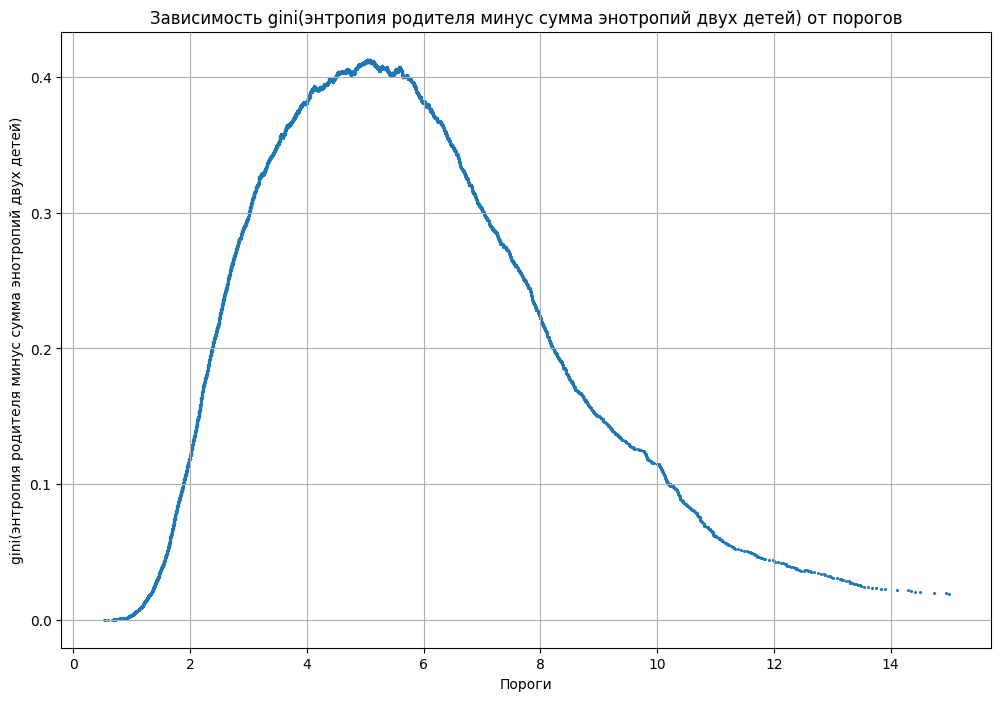

In [13]:
import matplotlib.pyplot as plt


plt.figure(figsize=(12, 8))
plt.scatter(thresholds, gini, s=1.5)

plt.xlabel("Пороги")
plt.ylabel("gini(энтропия родителя минус сумма энотропий двух детей)")


plt.title("Зависимость gini(энтропия родителя минус сумма энотропий двух детей) от порогов")
plt.grid(True)

plt.show()


Найдите лучший, с вашей точки зрения, предикат первой вершины решающего дерева.

In [14]:
answer=[]
for i in range(X.shape[1]):
    a = find_best_split(X.iloc[:, i], y, 'regression', 'real')
    answer.append([X.columns[i], a[2],a[3]])


In [15]:
answer = sorted(answer, key=lambda x: x[2], reverse=True)

In [16]:
answer

[['MedInc', 5.03515, 0.4127513862016766],
 ['AveRooms', 6.374305146225346, 0.15920795258922493],
 ['Latitude', 37.935, 0.0903340876537202],
 ['AveOccup', 3.1125433206272035, 0.07391870577793291],
 ['Longitude', -121.86500000000001, 0.05021105203303017],
 ['HouseAge', 51.5, 0.030900940598321158],
 ['AveBedrms', 1.1033776245480702, 0.01525341559594362],
 ['Population', 1160.5, 0.0028306480479909357]]

In [17]:
# лушчий предикат MedInc > 5.03515 (так как дает наибольший критерий информативности)

**Задание 2.2 (1 балл)** Разберитесь с написанным кодом решающего дерева, заполните пропуски в коде и реализуйте недостающий метод `_predict_node()`.

Построение дерева осуществляется согласно базовому жадному алгоритму, предложенному в лекции в разделе «Построение дерева».
- **Выбор лучшего разбиения** необходимо производить по критерию Джини.
- **Критерий останова:** все объекты в листе относятся к одному классу или ни по одному признаку нельзя разбить выборку.
- **Ответ в листе:** наиболее часто встречающийся класс в листе.

В задаче также предлагается получить два бонуса, по баллу на каждый!

- **Реализуйте способ обрабатывать пропуски в даннх и реализуйте его, пояснив свои действия.**
- **Реализуйте метод оценки важности признаков.**

In [18]:
class DecisionTree:

    def __init__(
        self,
        feature_types: Union[List[str], np.ndarray],
        max_depth: int = None,
        min_samples_split: int = None,
        min_samples_leaf: int = None,
        task: str = "classification"
    ) -> None:

        if np.any(list(map(lambda x: x != "real" and x != "categorical", feature_types))):
            raise ValueError("There is unknown feature type")

        # В этой переменной будем хранить узлы решающего дерева. Каждая вершина хранит в себе идентификатор того,
        # является ли она листовой. Листовые вершины хранят значение класса для предсказания, нелистовые - правого и
        # левого детей (поддеревья для продолжения процедуры предсказания)
        self._tree = {}

        # типы признаков (категориальные или числовые)
        self._feature_types = feature_types

        # гиперпараметры дерева
        self._max_depth = max_depth
        self._min_samples_split = min_samples_split
        self._min_samples_leaf = min_samples_leaf
        self.task = task

        # Переменная, если вы решите делать бонус
        self._feature_importances = {}


    def _fit_node(
        self,
        sub_X: np.ndarray,
        sub_y: np.ndarray,
        node: dict
    ) -> None:

        # критерий останова
        if np.all(sub_y == sub_y[0]):
            node["type"] = "terminal"
            node["class"] = sub_y[0]
            return

        feature_best, threshold_best, gini_best, split = None, None, None, None
        for feature in range(sub_X.shape[1]):
            feature_type = self._feature_types[feature]
            categories_map = {}

            # подготавливаем признак для поиска оптимального порога
            if feature_type == "real":
                feature_vector = sub_X[:, feature]
            elif feature_type == "categorical":
                # здесь могла быть реализация более сложного подхода к обработке категориального признака
                feature_vector = sub_X[:, feature]

            # ищем оптимальный порог
            _, _, threshold, gini = find_best_split(feature_vector, sub_y, self.task, feature_type)

            if gini_best is None or gini > gini_best:
                feature_best = feature
                gini_best = gini

                # split - маска на объекты, которые должны попасть в левое поддерево
                if feature_type == "real":
                    threshold_best = threshold
                    split = sub_X[:, feature] <= threshold_best
                elif feature_type == "categorical":
                    threshold_best = threshold
                    split = sub_X[:, feature] == threshold_best
                else:
                    raise ValueError

        # записываем полученные сплиты в атрибуты класса
        if feature_best is None:
            node["type"] = "terminal"
            node["class"] = Counter(sub_y).most_common(1)[0][0]
            return

        node["type"] = "nonterminal"

        node["feature_split"] = feature_best
        if self._feature_types[feature_best] == "real":
            node["threshold"] = threshold_best
        elif self._feature_types[feature_best] == "categorical":
            node["category_split"] = threshold_best
        else:
            raise ValueError

        node["left_child"], node["right_child"] = {}, {}
        self._fit_node(sub_X[split], sub_y[split], node["left_child"])
        self._fit_node(sub_X[np.logical_not(split)], sub_y[np.logical_not(split)], node["right_child"])

    def _predict_node(self, x: np.ndarray, node: dict) -> int:
        """
        Предсказание начинается с корневой вершины дерева и рекурсивно идёт в левое или правое поддерево в зависимости от значения
        предиката на объекте. Листовая вершина возвращает предсказание.
        :param x: np.array, элемент выборки
        :param node: dict, вершина дерева
        """

        if node["type"] == "terminal":
            return node["class"]

        feature = node["feature_split"]

        if self._feature_types[feature] == "categorical":
          if x[feature] == node["category_split"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])
        else:
          if x[feature] <= node["threshold"]:
            return self._predict_node(x, node["left_child"])
          else:
            return self._predict_node(x, node["right_child"])



    def fit(self, X: np.ndarray, y: np.ndarray) -> None:
        self._fit_node(X, y, self._tree)

    def predict(self, X: np.ndarray) -> np.ndarray:
        predicted = []
        for x in X:
            predicted.append(self._predict_node(x, self._tree))

        return np.array(predicted)

**Задание 2.3 (1 балл)** Загрузите таблицу `students.csv` (это немного преобразованный датасет [User Knowledge](https://archive.ics.uci.edu/ml/datasets/User+Knowledge+Modeling)). В ней признаки объекта записаны в первых пяти столбцах, а в последнем записана целевая переменная (класс: 0 или 1). Постройте на одном изображении пять кривых "порог — значение критерия Джини" для всех пяти признаков. Отдельно визуализируйте диаграммы рассеяния "значение признака — класс" для всех пяти признаков.

In [19]:
!wget 'https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv'


--2024-05-25 15:25:09--  https://raw.githubusercontent.com/hse-ds/iad-intro-ds/master/2024/homeworks/hw07-trees/students.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7794 (7.6K) [text/plain]
Saving to: ‘students.csv’

students.csv        100%[===================>]   7.61K  --.-KB/s    in 0s      

2024-05-25 15:25:09 (68.9 MB/s) - ‘students.csv’ saved [7794/7794]



In [20]:
df = pd.read_csv('/content/students.csv')

In [21]:
df = df.drop(columns=['Unnamed: 0'])

In [22]:
y=df['UNS']

In [23]:
y=np.array(y)

In [24]:
df = df.drop(columns=['UNS'])

In [25]:
df.columns

Index(['STG', 'SCG', 'STR', 'LPR', 'PEG'], dtype='object')

In [26]:
answers=[]
for i in df.columns:
  a=find_best_split(df[i],y,'classification','real')
  thresholds=a[0]
  gini=a[1]
  answers.append([i,thresholds,gini])



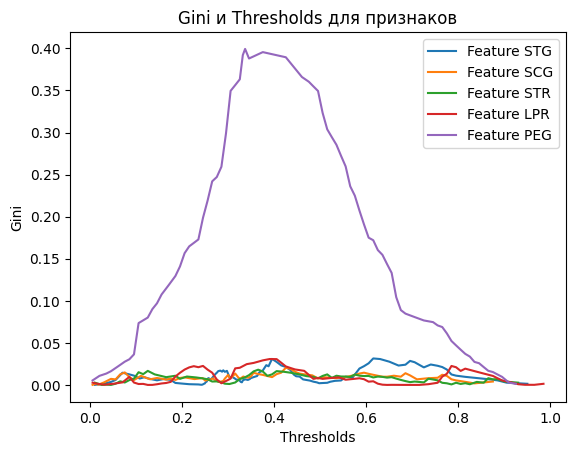

In [27]:
for name,thresholds, gini in answers:
    plt.plot(thresholds, gini, label=f'Feature {name}')


plt.xlabel('Thresholds')
plt.ylabel('Gini')
plt.legend()
plt.title('Gini и Thresholds для признаков')

plt.show()

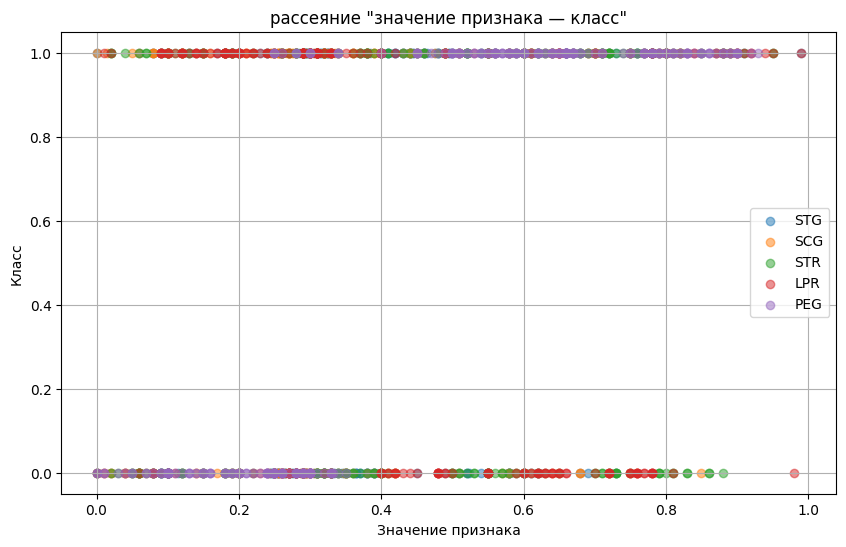

In [28]:
fig, ax = plt.subplots(figsize=(10, 6))
for feature in ['STG', 'SCG', 'STR', 'LPR', 'PEG']:
    ax.scatter(df[feature], y, label=feature, alpha=0.5)

plt.xlabel("Значение признака")
plt.ylabel("Класс")
plt.legend()
plt.grid(True)
plt.title('рассеяние "значение признака — класс"')
plt.show()


Исходя из кривых значений критерия Джини, по какому признаку нужно производить деление выборки на два поддерева? Согласуется ли этот результат с визуальной оценкой диаграмм рассеяиния? Как бы охарактеризовали вид кривой для "хороших" признаков, по которым выборка делится почти идеально? Чем отличаются кривые для признаков, по которым деление практически невозможно?

In [29]:
# на первом графике видно, что признак PEG дает наибольшую информативность при пороге примерно равном 0.4
# поэтому очевидно, что деление выборки нужно производить по этому признаку.
# результат полностью согласуется с визуальной оценкой диаграмм рассеяиния, так как видно что выборка достаточно точно разбивается при значении признака 0.4 (видно, что
# у объектов у которых признак PEG меньше чем 0.4 то у большинста из них класс 0, а у тех которых признак больше 0.4 класс 1, тоже можно сказать и про признак LPR, так как на
# 1 графике в точке 0.4 тоже достигается максимум критерия информативности для этого признака.)
#  вид кривой для "хороших" признаков, по которым выборка делится почти идеально характеризуется графиком у которой есть точка максимума(глобального)(то есть есть отрезок на котором она возрастает
# и на котором убывает, как паробола, к примеру(ветвями вверх)), у плохих же признаков график gini предстваляет из себя кривую, имеющую несколько локальных максимумов(действительно 'кривая' кривая
# по 2 графику также видно, что по ним выборка практически не делится)

**Задание 2.4 (1 балл)** Протестируйте свое решающее дерево на датасете [mushrooms](https://archive.ics.uci.edu/ml/datasets/Mushroom).

1. Скачайте таблицу `agaricus-lepiota.data` (из [Data Folder](https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/)),
2. Считайте таблицу при помощи `pandas`,
3. Примените к каждому столбцу `LabelEncoder` (из `sklearn`), чтобы преобразовать строковые имена категорий в натуральные числа.

Первый столбец — это целевая переменная (e — edible, p — poisonous) Мы будем измерять качество с помощью accuracy, так что нам не очень важно, что будет классом 1, а что — классом 0. Обучите решающее дерево на половине случайно выбранных объектов (признаки в датасете категориальные) и сделайте предсказания для оставшейся половины. Вычислите accuracy.

In [30]:

!wget 'https://archive.ics.uci.edu/static/public/73/mushroom.zip'


--2024-05-25 15:25:11--  https://archive.ics.uci.edu/static/public/73/mushroom.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: unspecified
Saving to: ‘mushroom.zip’

mushroom.zip            [ <=>                ] 138.01K  --.-KB/s    in 0.1s    

2024-05-25 15:25:11 (1.27 MB/s) - ‘mushroom.zip’ saved [141318]



In [31]:
!unzip mushroom.zip

Archive:  mushroom.zip
  inflating: Index                   
  inflating: README                  
  inflating: agaricus-lepiota.data   
  inflating: agaricus-lepiota.names  
  inflating: expanded.Z              


In [32]:
df=pd.read_csv('/content/agaricus-lepiota.data')

In [33]:
df

,p,x,s,n,t,p.1,f,c,n.1,k,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,e,x,s,y,t,a,f,c,b,k,...,s,w,w,p,w,o,p,n,n,g
1,e,b,s,w,t,l,f,c,b,n,...,s,w,w,p,w,o,p,n,n,m
2,p,x,y,w,t,p,f,c,n,n,...,s,w,w,p,w,o,p,k,s,u
3,e,x,s,g,f,n,f,w,b,k,...,s,w,w,p,w,o,e,n,a,g
4,e,x,y,y,t,a,f,c,b,n,...,s,w,w,p,w,o,p,k,n,g
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,e,k,s,n,f,n,a,c,b,y,...,s,o,o,p,o,o,p,b,c,l
8119,e,x,s,n,f,n,a,c,b,y,...,s,o,o,p,n,o,p,b,v,l
8120,e,f,s,n,f,n,a,c,b,n,...,s,o,o,p,o,o,p,b,c,l
8121,p,k,y,n,f,y,f,c,n,b,...,k,w,w,p,w,o,e,w,v,l


In [34]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()

for i in df.columns:
  df[i] = label_encoder.fit_transform(df[i])



In [35]:
y=np.array(df['p'])

In [36]:
df = df.drop(columns=['p'])
df

,x,s,n,t,p.1,f,c,n.1,k,e,...,s.2,w,w.1,p.2,w.2,o,p.3,k.1,s.3,u
0,5,2,9,1,0,1,0,0,4,0,...,2,7,7,0,2,1,4,3,2,1
1,0,2,8,1,3,1,0,0,5,0,...,2,7,7,0,2,1,4,3,2,3
2,5,3,8,1,6,1,0,1,5,0,...,2,7,7,0,2,1,4,2,3,5
3,5,2,3,0,5,1,1,0,4,1,...,2,7,7,0,2,1,0,3,0,1
4,5,3,9,1,0,1,0,0,5,0,...,2,7,7,0,2,1,4,2,2,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8118,3,2,4,0,5,0,0,0,11,0,...,2,5,5,0,1,1,4,0,1,2
8119,5,2,4,0,5,0,0,0,11,0,...,2,5,5,0,0,1,4,0,4,2
8120,2,2,4,0,5,0,0,0,5,0,...,2,5,5,0,1,1,4,0,1,2
8121,3,3,4,0,8,1,0,1,0,1,...,1,7,7,0,2,1,0,7,4,2


In [37]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(df,y,test_size=0.5, random_state=0)
X_train = X_train.to_numpy().astype(float)
X_test = X_test.to_numpy().astype(float)

In [38]:
X_train

array([[2., 3., 2., ..., 2., 4., 0.],
       [0., 2., 5., ..., 5., 4., 3.],
       [4., 0., 4., ..., 2., 4., 5.],
       ...,
       [5., 2., 3., ..., 2., 3., 1.],
       [5., 0., 2., ..., 2., 5., 0.],
       [5., 3., 3., ..., 2., 5., 0.]])

In [39]:
from sklearn.metrics import accuracy_score
tree_model = DecisionTree(feature_types=['real'] * 22 , task='classification')

tree_model.fit(X_train, y_train)

predictions = tree_model.predict(X_test)


accuracy = accuracy_score(y_test, predictions)
print("Accuracy:", accuracy)


Accuracy: 1.0


## Часть 3: Бэггинг и случайный лес (4 балла)

В данной части мы будем работать [с задачей предсказания диабета у пациента](https://www.kaggle.com/uciml/pima-indians-diabetes-database/data). Посмотрим на работу бэггинга над решающими деревьями и случайного леса, сравним их работу.

In [40]:
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_auc_score
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier

In [41]:
!kaggle datasets download -d uciml/pima-indians-diabetes-database
!unzip /content/pima-indians-diabetes-database.zip

Dataset URL: https://www.kaggle.com/datasets/uciml/pima-indians-diabetes-database
License(s): CC0-1.0
  0% 0.00/8.91k [00:00<?, ?B/s]
100% 8.91k/8.91k [00:00<00:00, 19.7MB/s]
Archive:  /content/pima-indians-diabetes-database.zip
  inflating: diabetes.csv            


In [42]:
data = pd.read_csv('diabetes.csv')
print(f"Dataset shape: {data.shape}")
data.head()


Dataset shape: (768, 9)


,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


Посмотрим на распределение целевой переменной

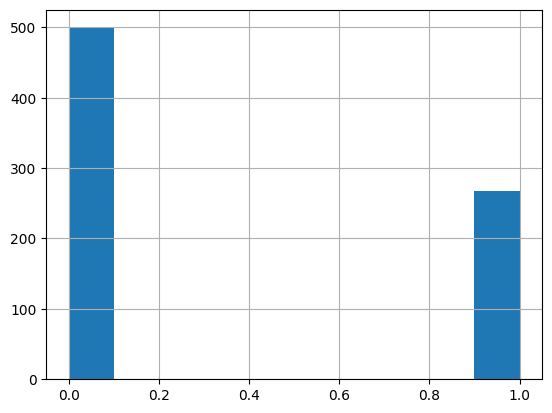

In [43]:
data['Outcome'].hist()
plt.show()

In [44]:
y=data['Outcome']

In [45]:
data = data.drop(columns=['Outcome'])

**Задание 3.1 (0.5 балла)** Разделите данные на признаки и целевую переменную. Разбейте датасет на обучающую и тестовую части в отношении 7:3. Затем разделите обучающую выборку на обучающую-обучающую и обучающую-валидационную в соотношении 7:3 (то есть в итоге должно получиться три выборки: обучающая-обучающая (0.49 от исходного датасета), обучающая-валидационная (0.21 от исходного датасета) и тестовая (0.3 от исходного датасета).

In [46]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(data,y,test_size=0.3, random_state=2004)

In [47]:
X_train_train,X_train_val, y_train_train,y_train_val=train_test_split(X_train,y_train,test_size=0.3, random_state=2004)

**Задание 3.2 (1 балл)** На обучающей-валидационной выборке подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_leaf` для `DecisionTreeClassifier`. Для этого:
1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений обучите дерево на обучающей-обучающей выборке и определите качество на обучающей-валидационной выборке. В качестве критерия будем использовать `f1-меру`.
3. Выберите ту пару значений, которая даёт наилучшее качество на обучающей-валидационной выборке.


Обучите решающее дерево с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по метрикам `accuracy`, `precision` и `recall`, `auc_roc`.

In [48]:
from sklearn.model_selection import GridSearchCV
parametrs = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17],
    'min_samples_leaf': [1,2,3,4,5,6,7,8,9,10,11,12,13,14,15]

}
tree = DecisionTreeClassifier()
grid_search = GridSearchCV(tree, parametrs,scoring='f1', cv=None)
grid_search.fit(X_train_val, y_train_val)

GridSearchCV(estimator=DecisionTreeClassifier(),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12,
                                       13, 14, 15, 16, 17],
                         'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                              12, 13, 14, 15]},
             scoring='f1')

In [49]:
print("Best parameters:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)

Best parameters: {'max_depth': 5, 'min_samples_leaf': 14}
Best f1 score: 0.6201585081585081


In [62]:
tree_final = DecisionTreeClassifier(max_depth=5,min_samples_leaf=14)
tree_final.fit(X_train,y_train)
y_pred = tree_final.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc)

Accuracy: 0.7835497835497836
Precision: 0.6944444444444444
Recall: 0.6410256410256411
AUC-ROC: 0.7486173956762192


**Задание 3.3 (0.5 балла)** Обучите [`BaggingClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingClassifier.html) на 50 деревьях на **полной обучающей** выборке. Оцените качество классификации на тестовой выборке по тем же метрикам.

In [63]:
bagging = BaggingClassifier(base_estimator=DecisionTreeClassifier(), n_estimators=50, random_state=2004)
bagging.fit(X_train,y_train)
y_pred = bagging.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc)

/usr/local/lib/python3.10/dist-packages/sklearn/ensemble/_base.py:166: FutureWarning: `base_estimator` was renamed to `estimator` in version 1.2 and will be removed in 1.4.
  warnings.warn(


Accuracy: 0.7575757575757576
Precision: 0.6486486486486487
Recall: 0.6153846153846154
AUC-ROC: 0.7227249874308698


**Задание 3.4 (1 балл)** Выполните кросс-валидацию на полной обучающей выборке и подберите оптимальные значения гиперпараметров `max_depth` и `min_samples_split` для `Random Forest` с 50 деревьями. Для этого:

1. Создайте списки с возможными значениями для перебора.
2. Для каждой пары значений проведите кросс-валидацию на полной обучающей выборке. Количество разбиений выберите на ваш вкус. В качестве критерия будем использовать `f1-меру`. Усредните значение критерия по всем прогонам кросс-валидации.
3. Выберите ту пару значений, которая даёт наилучшее среднее качество.

Обучите случайный лес с подобранными гиперпараметрами на **полной обучающей** выборке. Оцените качество классификации по тем же метрикам. Какая из трёх построенных моделей показала себя лучше?

In [64]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
parametrs = {
    'max_depth': [1,2,3,4,5,6,7,8,9,10],
    'min_samples_split': [2,3,4,5,6,7]

}
random_forest_model = RandomForestClassifier(n_estimators=50, random_state=2004)
grid_search = GridSearchCV(random_forest_model, parametrs,scoring='f1', cv=5)
grid_search.fit(X_train, y_train)

GridSearchCV(cv=5,
             estimator=RandomForestClassifier(n_estimators=50,
                                              random_state=2004),
             param_grid={'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
                         'min_samples_split': [2, 3, 4, 5, 6, 7]},
             scoring='f1')

In [65]:
print("Best parameters:", grid_search.best_params_)
print("Best f1 score:", grid_search.best_score_)

Best parameters: {'max_depth': 10, 'min_samples_split': 6}
Best f1 score: 0.6350615713115714


In [66]:
random_forest_model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=6, random_state=2004)
random_forest_model.fit(X_train,y_train)
y_pred = random_forest_model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
auc_roc = roc_auc_score(y_test, y_pred)
print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("AUC-ROC:", auc_roc)

Accuracy: 0.7619047619047619
Precision: 0.6575342465753424
Recall: 0.6153846153846154
AUC-ROC: 0.725992961287079


In [55]:
# лучше всего себя показала 1 модель (max_depth и min_samples_leaf для DecisionTreeClassifier)
# не смотря на то, что 1 была лушче остальных все очень сильно зависит от random state и при разных могут быть разные показатели.

**Задание 3.5 (0.5 балла)** Постройте график зависимости AUC ROC на тестовой выборке от числа деревьев (`n_estimators`) для случайного леса, обучаемого на **полной обучающей** выборке. Какие выводы можно сделать?

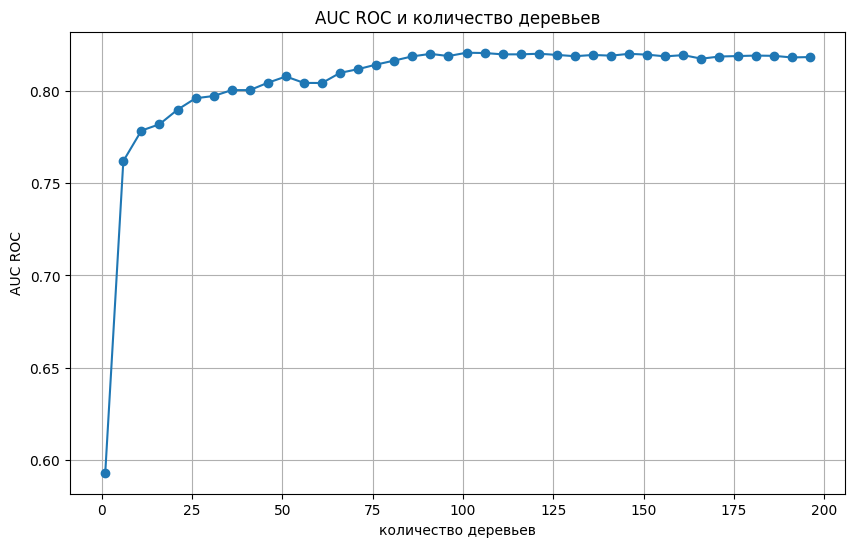

In [56]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_auc_score

estimators_range = range(1, 200, 5)
estimators_list = []
auc_roc_list = []

for estimators in estimators_range:
    model = RandomForestClassifier(n_estimators=estimators, random_state=0)
    model.fit(X_train, y_train)

    y_pred_proba = model.predict_proba(X_test)[:, 1]
    auc_roc = roc_auc_score(y_test, y_pred_proba)

    estimators_list.append(estimators)
    auc_roc_list.append(auc_roc)

plt.figure(figsize=(10, 6))
plt.plot(estimators_list, auc_roc_list, marker='o', linestyle='-')
plt.xlabel('количество деревьев')
plt.ylabel('AUC ROC')
plt.title('AUC ROC и количество деревьев')
plt.grid(True)
plt.show()


In [57]:
# как видно из графика, начиная с определенного количества деревьев(в данном случае около 100) auc roc перестает увеличиваться и выходит на асимптоту, то есть при использование randomforest можно останавливаться на определенном количестве деревьев и результаты не будут улучшаться

**Задание 3.6 (0.5 балла)** Для лучшей модели случайного леса из **Задания 3.4** посчитайте важность признаков и постройте bar plot. Какой признак оказался самым важным для определения диабета?

In [58]:
model = RandomForestClassifier(n_estimators=50, max_depth=10, min_samples_split=6, random_state=2004)
model.fit(X_train,y_train)
feature_importance = model.feature_importances_

In [59]:
feature_importance

array([0.07515777, 0.2527204 , 0.08251688, 0.07900696, 0.06266167,
       0.20745873, 0.12708815, 0.11338945])

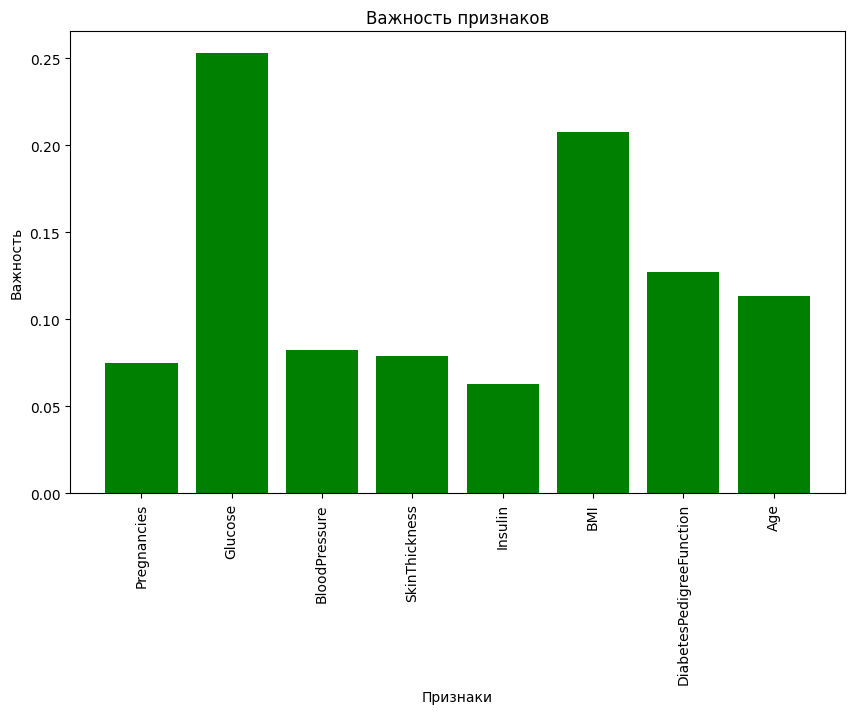

In [60]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))

x = X_train.columns
y = feature_importance

plt.bar(x, y, color='green')

plt.xlabel('Признаки')
plt.ylabel('Важность')
plt.title('Важность признаков')

plt.xticks(rotation=90)

plt.show()

In [61]:
#  Самым важным признаком оказалась Глюкоза(в среднем наибольший критерий информативности)